# 1. Data Collection

This notebook collects, cleans, and prepares comments from various threads in 4chan's [API](https://github.com/4chan/4chan-API/blob/master/pages/Threads.md). It completes exploratory and descriminative data analysis on the comments. It also explores a few types of classification models to identify whether a model could be built that is better than simply guessing (baseline model).

In [1]:
# imports
import requests
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

### Collect and save data for the various 4chan boards

In [2]:
def collect_thread_list(board):
    """ This function pulls down data from a given channel using the 4chan API and returns the 
    data as a Pandas DataFrame.
    
    args:
        board (str): name of a board/channel
    
    return:
        df (Pandas DataFrame): a data frame of a list of threads
    """
    url = 'https://a.4cdn.org/' + board + '/threads.json'
    res = requests.get(url)
    if res.status_code == 200:
        threads = pd.DataFrame([thread for page in res.json() for thread in page['threads']])
        time.sleep(1)
        return threads[0:100]
    else:
        print('request_failed')

In [3]:
def collect_thread_info(board):
    """ This function pulls down thread information from a given board and thread number using the 4chan API and returns the 
    data as a Pandas DataFrame.
    
    args:
        board (str): name of a board/channel
        threads (Pandas DataFrame): a data frame of a list of threads
    
    return:
        all_posts (Pandas DataFrame): a data frame of a list of posts and their metadata
    """
    threads = collect_thread_list(board)
    flag = True
    for thread_no in threads['no']:
        url = 'https://a.4cdn.org/' + board + '/thread/' + str(thread_no) + '.json'
        res = requests.get(url)
        if res.status_code == 200:
            # print([post for post in res.json()['posts']])
            comments = [post['com'] for post in res.json()['posts'] if 'com' in post.keys()]
            thread_posts = pd.DataFrame([BeautifulSoup(comment).get_text() for comment in comments], columns=['post'])
            thread_posts['time'] = [post['time'] for post in res.json()['posts'] if 'com' in post.keys()]
            thread_posts['board'] = board
            thread_posts['thread'] = thread_no
            if flag:
                all_posts = thread_posts
                flag = False
            else:
                all_posts = pd.concat([all_posts,thread_posts],)
            time.sleep(1)
        else:
            print('request_failed')
            return all_posts
    return all_posts

In [4]:
# # Collect posts from all four desired boards, Technology (/g/), TV & Film (/tv/), Food & Cooking (/ck/), and Literature (/lit).

# boards = ['g','tv','ck','lit']

# posts = collect_thread_info(boards[0])

# for board in boards[1::]:
#     posts = pd.concat([posts,collect_thread_info(board)],)

# posts.reset_index(drop=True,inplace=True)

In [5]:
# # Let's save these posts in a csv file and save to local file
# posts.to_csv('../datasets/posts.csv',index=False)

### Exploratory Data Analysis

In [6]:
# Import posts collected using the script above
posts = pd.read_csv('../datasets/posts.csv')

In [7]:
posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17619 entries, 0 to 17618
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   post    17619 non-null  object 
 1   time    17619 non-null  float64
 2   board   17619 non-null  object 
 3   thread  17619 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 550.7+ KB


We have 17,619 posts collected from the four boards, with no null values.

In [8]:
posts.sample(5)

,post,time,board,thread
9198,>>167389575Unironically a far better actor.,1.651437e+09,tv,167389041
958,Are there any reasons to buy an x220 over an x...,1.651382e+09,g,86699693
1142,>>86760619It's a week's salary for a computer ...,1.651433e+09,g,86756834
3359,">>86755497>but other than that, what's wrong w...",1.651406e+09,g,86741732
4471,>>86759872lol look at what your money is being...,1.651435e+09,g,86759872


In [9]:
posts['board'].value_counts(normalize=True)

g      0.301493
tv     0.244679
ck     0.234803
lit    0.219025
Name: board, dtype: float64

The distribution is fairly balanced, although there are more posts from technology and less from literature.

#### Let's try to remove post/thread numbers from posts by removing all numbers.

Justification: I am removing all numbers, so we may lose some information from the posts that may help classify, but we will see if we can still classify the posts with text.

In [10]:
posts['post'] = [''.join([i for i in post if ((not i.isdigit()) & (i not in '>'))]) for post in posts['post']]

In [11]:
posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17619 entries, 0 to 17618
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   post    17619 non-null  object 
 1   time    17619 non-null  float64
 2   board   17619 non-null  object 
 3   thread  17619 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 550.7+ KB


Still no non-null after the removal of numbers and '>'

#### Let's look at length of posts and number of words in each posts.

In [12]:
posts['post_length'] = posts['post'].apply(len)

In [13]:
posts

,post,time,board,thread,post_length
0,This board is for the discussion of technology...,1.594687e+09,g,76759434,367
1,Systemd is...le good?,1.651441e+09,g,86762517,21
2,What is wrong with systemd other than it viola...,1.651442e+09,g,86762517,277
3,violating a philosophyThe Unix philosophy? But...,1.651443e+09,g,86762517,67
4,Is it possible? Has it been done? If so how do...,1.651439e+09,g,86762147,55
...,...,...,...,...,...
17614,"""not my fault you're bleeding but let me shit ...",1.651429e+09,lit,20306707,59
17615,I'll check it out fren,1.651429e+09,lit,20306707,22
17616,Maybe I'd piss and cum on it as well.,1.651430e+09,lit,20306707,37
17617,procrastinating with yet another self-help book,1.651430e+09,lit,20306707,47


In [14]:
posts['post_word_count'] = posts['post'].apply(str.split).apply(len)

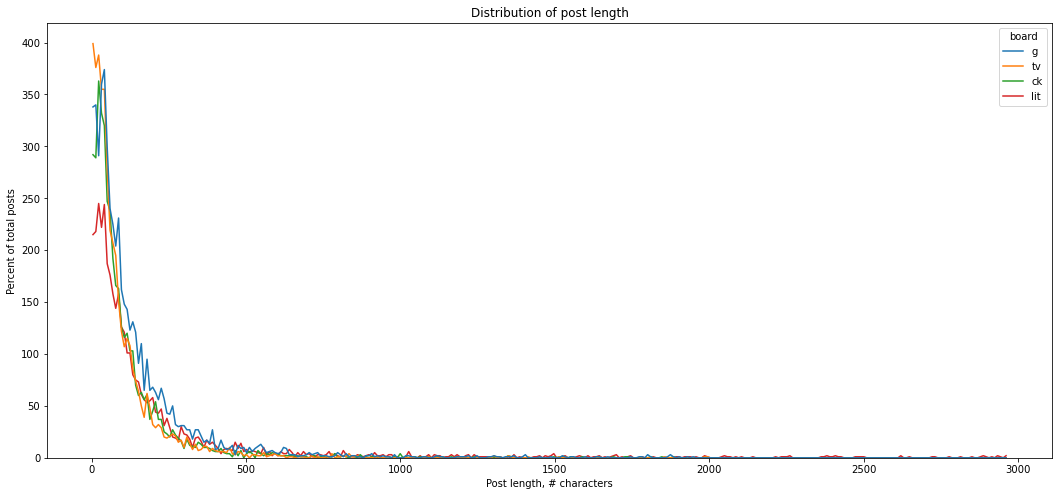

In [15]:
plt.figure(figsize = (18,8))
sns.histplot(data = posts, x='post_length',hue='board',fill=False,element='poly')
plt.title('Distribution of post length')
plt.xlabel('Post length, # characters')
plt.ylabel('Percent of total posts');

Fairly similar distribution of post lengths, although it seems literature posts tend to be longer.

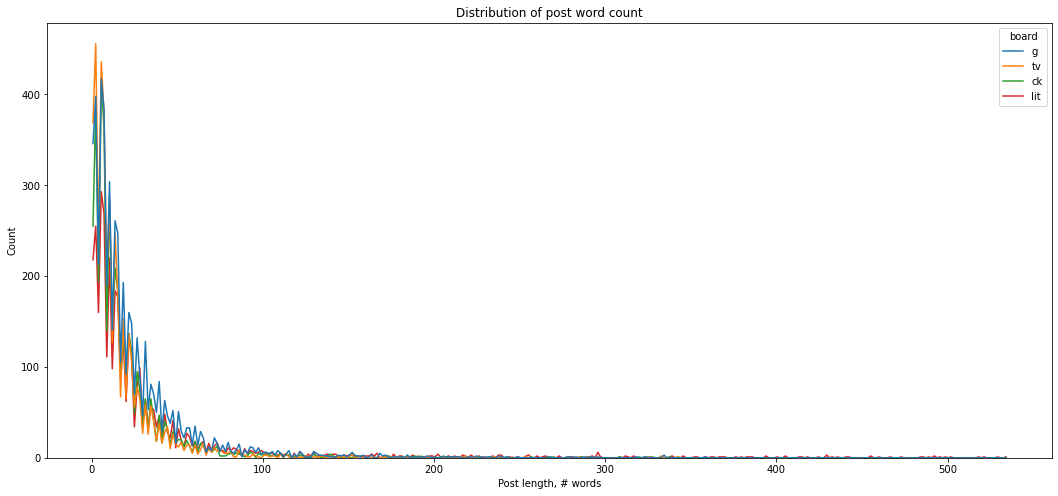

In [16]:
plt.figure(figsize = (18,8))
sns.histplot(data = posts, x='post_word_count',hue='board',fill=False,element='poly',)
plt.title('Distribution of post word count')
plt.xlabel('Post length, # words')
plt.ylabel('Count');

Also a fairly similar distribution of number of words in each post.

#### Let's see if there are any duplicate posts.

In [17]:
posts.shape

(17619, 6)

In [18]:
posts.drop_duplicates(subset=['post'])

,post,time,board,thread,post_length,post_word_count
0,This board is for the discussion of technology...,1.594687e+09,g,76759434,367,55
1,Systemd is...le good?,1.651441e+09,g,86762517,21,3
2,What is wrong with systemd other than it viola...,1.651442e+09,g,86762517,277,47
3,violating a philosophyThe Unix philosophy? But...,1.651443e+09,g,86762517,67,10
4,Is it possible? Has it been done? If so how do...,1.651439e+09,g,86762147,55,14
...,...,...,...,...,...,...
17614,"""not my fault you're bleeding but let me shit ...",1.651429e+09,lit,20306707,59,12
17615,I'll check it out fren,1.651429e+09,lit,20306707,22,5
17616,Maybe I'd piss and cum on it as well.,1.651430e+09,lit,20306707,37,9
17617,procrastinating with yet another self-help book,1.651430e+09,lit,20306707,47,6


There seem to be a few duplicates.

In [19]:
threads = posts['thread'].unique()

In [20]:
post_count = list(zip(posts['post'].value_counts().keys(),posts['post'].value_counts()))

In [21]:
post_count[0:20]

[('', 274),
 ('based', 23),
 ('kek', 19),
 ('Bump', 14),
 ('Based', 12),
 ('bump', 11),
 ('this', 9),
 ('Kek', 8),
 ('test', 7),
 ('no', 7),
 ('Yes.', 7),
 ('Yes', 6),
 ('No.', 5),
 ('lol', 5),
 ('/thread', 5),
 ('yes', 4),
 ('KEK', 4),
 ('literally me', 4),
 ('Based.', 4),
 ('Fuck you', 3)]

Some duplicates are simply just common words, but there is a large category where after removing numbers and '>', there is no more text. Let's drop these rows.

In [22]:
posts.drop(index=posts[posts['post'] == ''].index, inplace = True)

In [23]:
posts.shape

(17345, 6)

In [24]:
posts['board'].value_counts(normalize=True)

g      0.303661
tv     0.242260
ck     0.234016
lit    0.220063
Name: board, dtype: float64

Technology still is overrepresented, but the data is still decently balanced.

#### Save Cleaned DF for use in other notebooks

In [25]:
#posts.to_csv('../datasets/posts_cleaned.csv',index=False)

### EDA on Word Counts

#### Instantiate and fit Count Vectorizer for selftext

In [26]:
cv = CountVectorizer(stop_words='english',ngram_range=(1,2),min_df=4,max_df=1.0,strip_accents='ascii')

In [27]:
posts_vect = cv.fit_transform(posts['post'])

In [28]:
df_posts_vect = pd.DataFrame(posts_vect.A, columns=cv.get_feature_names_out())

In [29]:
df_posts_vect['board'] = [x for x in posts['board']]

In [30]:
most_common_words = pd.DataFrame(df_posts_vect.drop(columns=['board']).sum().sort_values(ascending=False).head(100), columns=['combined'])

In [31]:
most_common_words_g = pd.DataFrame(df_posts_vect[df_posts_vect['board']=='g'].drop(columns=['board']).sum().sort_values(ascending=False).head(100), columns=['g'])
most_common_words_tv = pd.DataFrame(df_posts_vect[df_posts_vect['board']=='tv'].drop(columns=['board']).sum().sort_values(ascending=False).head(100), columns=['tv'])
most_common_words_ck = pd.DataFrame(df_posts_vect[df_posts_vect['board']=='ck'].drop(columns=['board']).sum().sort_values(ascending=False).head(100), columns=['ck'])
most_common_words_lit = pd.DataFrame(df_posts_vect[df_posts_vect['board']=='lit'].drop(columns=['board']).sum().sort_values(ascending=False).head(100), columns=['lit'])

In [32]:
most_common_words = most_common_words.join([most_common_words_g,most_common_words_tv,most_common_words_ck,most_common_words_lit], how = 'outer')

In [33]:
most_common_words

,combined,g,tv,ck,lit
like,2464.0,780.0,457.0,677.0,550.0
just,2228.0,829.0,393.0,445.0,561.0
don,1375.0,484.0,173.0,304.0,414.0
good,1072.0,336.0,159.0,289.0,288.0
people,1005.0,235.0,252.0,181.0,337.0
...,...,...,...,...,...
far,NaN,NaN,NaN,NaN,74.0
self,NaN,NaN,NaN,NaN,71.0
having,NaN,NaN,NaN,NaN,70.0
idea,NaN,NaN,NaN,NaN,69.0


In [34]:
board_posts = posts['board'].value_counts()

In [35]:
for board in board_posts.keys():
    most_common_words[board + '_freq'] = [count/board_posts[board] for count in most_common_words[board]]

In [36]:
most_common_words.iloc[0:50,:]

,combined,g,tv,ck,lit,g_freq,tv_freq,ck_freq,lit_freq
like,2464.0,780.0,457.0,677.0,550.0,0.148092,0.108758,0.166790,0.144092
just,2228.0,829.0,393.0,445.0,561.0,0.157395,0.093527,0.109633,0.146974
don,1375.0,484.0,173.0,304.0,414.0,0.091893,0.041171,0.074895,0.108462
good,1072.0,336.0,159.0,289.0,288.0,0.063793,0.037839,0.071200,0.075452
people,1005.0,235.0,252.0,181.0,337.0,0.044617,0.059971,0.044592,0.088289
want,816.0,362.0,76.0,144.0,234.0,0.068730,0.018087,0.035477,0.061305
think,793.0,228.0,146.0,144.0,275.0,0.043288,0.034745,0.035477,0.072046
shit,783.0,275.0,202.0,179.0,127.0,0.052212,0.048072,0.044100,0.033272
use,775.0,489.0,NaN,204.0,NaN,0.092842,NaN,0.050259,NaN
make,762.0,256.0,132.0,182.0,192.0,0.048605,0.031414,0.044839,0.050301


Many of the most common words are shared, but some are more prevalent than others in each board. Additionally, there are some words that appear frequently in some board but not in the top 100 for others.

#### Messages per thread

In [37]:
messages_per_thread = posts[['thread','board']].drop_duplicates(subset='thread')

In [38]:
messages_per_thread['messages'] = [posts[posts['thread'] == thread].shape[0] for thread in messages_per_thread['thread']]

In [39]:
messages_per_thread

,thread,board,messages
0,76759434,g,1
1,86762517,g,3
4,86762147,g,16
20,86762745,g,4
24,86761771,g,6
...,...,...,...
17568,20306789,lit,3
17571,20302812,lit,20
17592,20305453,lit,12
17604,20306182,lit,3


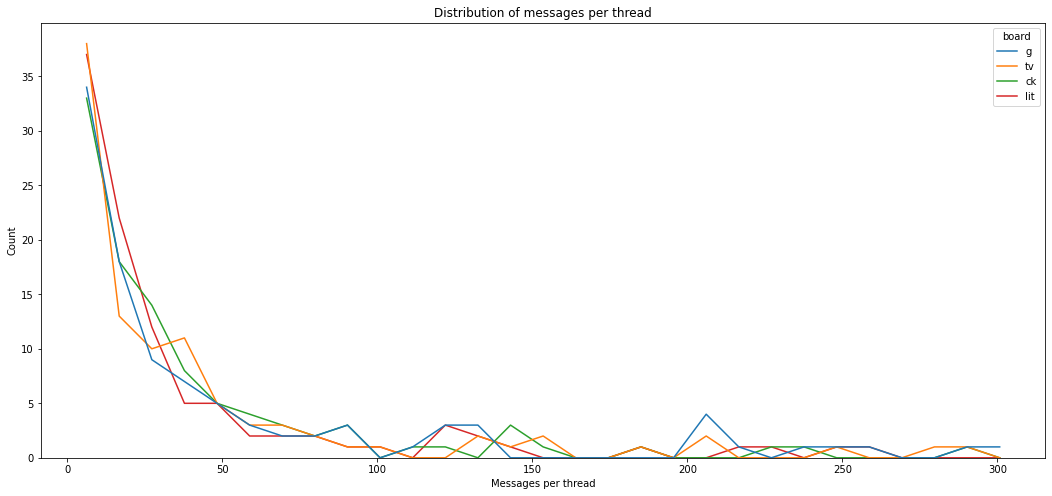

In [40]:
plt.figure(figsize = (18,8))
sns.histplot(data = messages_per_thread, x='messages',hue='board',fill=False,element='poly',)
plt.title('Distribution of messages per thread')
plt.xlabel('Messages per thread')
plt.ylabel('Count');

Most threads have fewer than 50 messages/posts per thread, although this number can increase to the hundreds. It seems that none of the boards we are examining have significantly different distributions.

#### Descriminative Analysis

Let's analyze words and signals that differentiate the boards by checking words that are much more frequent in a board compared to another.

In [41]:
most_common_words.sort_values(by='g',ascending=False).head(15)

,combined,g,tv,ck,lit,g_freq,tv_freq,ck_freq,lit_freq
just,2228.0,829.0,393.0,445.0,561.0,0.157395,0.093527,0.109633,0.146974
like,2464.0,780.0,457.0,677.0,550.0,0.148092,0.108758,0.166790,0.144092
use,775.0,489.0,NaN,204.0,NaN,0.092842,NaN,0.050259,NaN
don,1375.0,484.0,173.0,304.0,414.0,0.091893,0.041171,0.074895,0.108462
mint,401.0,398.0,NaN,NaN,NaN,0.075565,NaN,NaN,NaN
want,816.0,362.0,76.0,144.0,234.0,0.068730,0.018087,0.035477,0.061305
good,1072.0,336.0,159.0,289.0,288.0,0.063793,0.037839,0.071200,0.075452
nigger,330.0,290.0,NaN,NaN,NaN,0.055060,NaN,NaN,NaN
com,448.0,285.0,NaN,NaN,77.0,0.054110,NaN,NaN,0.020173
https,434.0,275.0,NaN,NaN,89.0,0.052212,NaN,NaN,0.023317


In [42]:
most_common_words.sort_values(by='tv',ascending=False).head(10)

,combined,g,tv,ck,lit,g_freq,tv_freq,ck_freq,lit_freq
like,2464.0,780.0,457.0,677.0,550.0,0.148092,0.108758,0.166790,0.144092
just,2228.0,829.0,393.0,445.0,561.0,0.157395,0.093527,0.109633,0.146974
people,1005.0,235.0,252.0,181.0,337.0,0.044617,0.059971,0.044592,0.088289
shit,783.0,275.0,202.0,179.0,127.0,0.052212,0.048072,0.044100,0.033272
movie,228.0,NaN,197.0,NaN,NaN,NaN,0.046882,NaN,NaN
don,1375.0,484.0,173.0,304.0,414.0,0.091893,0.041171,0.074895,0.108462
fucking,541.0,190.0,159.0,117.0,75.0,0.036074,0.037839,0.028825,0.019649
good,1072.0,336.0,159.0,289.0,288.0,0.063793,0.037839,0.071200,0.075452
did,497.0,108.0,154.0,73.0,162.0,0.020505,0.036649,0.017985,0.042442
think,793.0,228.0,146.0,144.0,275.0,0.043288,0.034745,0.035477,0.072046


In [43]:
most_common_words.sort_values(by='ck',ascending=False).head(10)

,combined,g,tv,ck,lit,g_freq,tv_freq,ck_freq,lit_freq
like,2464.0,780.0,457.0,677.0,550.0,0.148092,0.108758,0.166790,0.144092
just,2228.0,829.0,393.0,445.0,561.0,0.157395,0.093527,0.109633,0.146974
don,1375.0,484.0,173.0,304.0,414.0,0.091893,0.041171,0.074895,0.108462
good,1072.0,336.0,159.0,289.0,288.0,0.063793,0.037839,0.071200,0.075452
food,278.0,NaN,NaN,219.0,NaN,NaN,NaN,0.053954,NaN
use,775.0,489.0,NaN,204.0,NaN,0.092842,NaN,0.050259,NaN
eat,221.0,NaN,NaN,189.0,NaN,NaN,NaN,0.046563,NaN
oil,NaN,NaN,NaN,187.0,NaN,NaN,NaN,0.046070,NaN
really,741.0,219.0,144.0,184.0,194.0,0.041580,0.034269,0.045331,0.050825
make,762.0,256.0,132.0,182.0,192.0,0.048605,0.031414,0.044839,0.050301


In [44]:
most_common_words.sort_values(by='lit',ascending=False).head(10)

,combined,g,tv,ck,lit,g_freq,tv_freq,ck_freq,lit_freq
just,2228.0,829.0,393.0,445.0,561.0,0.157395,0.093527,0.109633,0.146974
like,2464.0,780.0,457.0,677.0,550.0,0.148092,0.108758,0.166790,0.144092
read,563.0,NaN,NaN,NaN,437.0,NaN,NaN,NaN,0.114488
don,1375.0,484.0,173.0,304.0,414.0,0.091893,0.041171,0.074895,0.108462
people,1005.0,235.0,252.0,181.0,337.0,0.044617,0.059971,0.044592,0.088289
book,376.0,NaN,NaN,NaN,335.0,NaN,NaN,NaN,0.087765
good,1072.0,336.0,159.0,289.0,288.0,0.063793,0.037839,0.071200,0.075452
think,793.0,228.0,146.0,144.0,275.0,0.043288,0.034745,0.035477,0.072046
want,816.0,362.0,76.0,144.0,234.0,0.068730,0.018087,0.035477,0.061305
time,730.0,215.0,124.0,158.0,233.0,0.040820,0.029510,0.038926,0.061043


Based on the frequncies of the word in each of the boards, it seems that there are some words that are common in some boards, but not in others. Ex:
- use (much more common for technology and cooking)
- com & https (technology and literature)
- n-word, mint (technology)
- movie (tv)
- food, eat, oil (cooking)
- read, people, book, think (literature)


### Modeling

In [45]:
X = posts['post']
y = posts['board']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42,stratify=y)

In [47]:
test_counts = y_test.value_counts()
test_counts

g      1317
tv     1051
ck     1015
lit     954
Name: board, dtype: int64

In [48]:
baseline = test_counts[0]/sum(test_counts)

In [49]:
print(f'Baseline accuracy is {round(baseline*100,1)}%.')

Baseline accuracy is 30.4%.


In [50]:
pipe_lr = Pipeline([
    ('cv', CountVectorizer(stop_words='english',ngram_range=(1,1),min_df=1,max_df=1.0,strip_accents='ascii')),
    ('lr', LogisticRegression(random_state=42,max_iter=1_000))
])
pipe_lr.fit(X_train, y_train)
pipe_lr.score(X_train, y_train), pipe_lr.score(X_test, y_test)

(0.9279674046740467, 0.658750288217662)

The logistic regression model appears to be overfit. Later improvements to the model could be using an ensemble to increase bias.

In [51]:
pipe_rf = Pipeline([
    ('cv', CountVectorizer(stop_words='english',ngram_range=(1,2),min_df=4,max_df=1.0,strip_accents='ascii')),
    ('rf', RandomForestClassifier(max_depth=None,n_estimators=500,random_state=42))
])
pipe_rf.fit(X_train, y_train)
pipe_rf.score(X_train, y_train), pipe_rf.score(X_test, y_test)

(0.9441881918819188, 0.5801245100299747)

Same comment as with logistic regression.

In [52]:
pipe_mnb = Pipeline([
    ('cv', CountVectorizer(stop_words='english',ngram_range=(1,3),min_df=4,max_df=1.0,strip_accents='ascii')),
    ('mnb', MultinomialNB(alpha=1))
])
pipe_mnb.fit(X_train, y_train)
pipe_mnb.score(X_train, y_train), pipe_mnb.score(X_test, y_test)

(0.748769987699877, 0.6670509568826377)

Reduced variance than logistic regression and random forests, but still fairly overfit.

In [53]:
pipelines = [pipe_lr, pipe_rf, pipe_mnb]

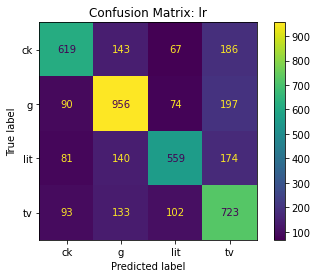

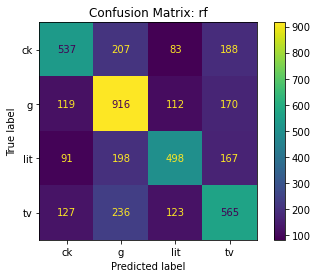

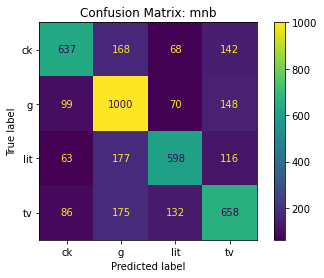

In [54]:
def confusion(pipe):
    ConfusionMatrixDisplay.from_estimator(pipe,X_test,y_test)
    plt.title(f'Confusion Matrix: {list(pipe.named_steps.keys())[1]}');

for pipe in pipelines:
    confusion(pipe);

Our models are very strong at predicting technology, but weaker at prediciting the other boards.

In [55]:
misclassifications= pd.DataFrame(X_test)

In [56]:
misclassifications['true class'] = y_test

In [57]:
misclassifications['LR pred class'] = pipe_lr.predict(X_test)
misclassifications['RF pred class'] = pipe_rf.predict(X_test)
misclassifications['MNB pred class'] = pipe_mnb.predict(X_test)

In [58]:
misclassifications[misclassifications['true class'] != misclassifications['MNB pred class']]

,post,true class,LR pred class,RF pred class,MNB pred class
11220,anyone else think sourdough is gay as fuck?,ck,tv,g,tv
7399,small postsmall reply posttwo paragraph reddit...,tv,g,g,lit
16954,Stephen,lit,tv,g,g
12029,"This guy isn't dead, is he?",ck,tv,tv,tv
13159,Test post,ck,g,ck,g
...,...,...,...,...,...
7703,Giwtwm,tv,tv,g,g
7579,humiliatingbased,tv,tv,g,g
656,cute anon,g,tv,tv,tv
3324,"not necessarily I don't, noI don't think eatin...",g,g,ck,ck


Overall, the models made substantial progress in classification when compared to the baseline model (30% accuracy). My next steps to iterate on the model would be to perform a gridsearch on the model parameters and implement a voting classifier or boosting algorithm. I would also want to take a look at the misclassifications (above) to see if there are clues to words/phrases where the model is struggling, and see if we can target those either through the voting classifier or tweaks to the count vectorizer.